In [1]:
from vyper.user import Model
import pandas as pd
from sklearn.utils import shuffle
from vyper.user.explorer import DataProfiler
from openpyxl import Workbook

import math
import numpy as np
from vyper.utils.tools import StatisticalTools as st
from sklearn.preprocessing import OrdinalEncoder
import scipy as stats
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from varclushi import VarClusHi
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [2]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from matplotlib.cm import viridis

In [3]:
class GMM:
    def __init__(self, data):
        self.df = pd.read_csv(data)
        # self.df = self.df.iloc[:50000, :]

    def get_shape(self):
        return self.df.shape

    def get_df(self):
        return self.df

    @staticmethod
    def silhouette(estimator, df, metric='euclidean'):
        labels = estimator.fit_predict(df)
        score = silhouette_score(df, labels, metric=metric)
        return score

    @staticmethod
    def get_training_history(training_history):
        return pd.DataFrame.from_dict(training_history)

    def gridSearchCV_gmm(self, grid, cv=5, rand_sample_prop=0.2):
        sample_data = self.df.sample(frac=rand_sample_prop)
        gmm = GaussianMixture()
        grid_search = GridSearchCV(estimator=gmm, param_grid=grid, cv=cv, scoring=self.silhouette)
        grid_search.fit(sample_data)
        # grid_search.fit(self.df)
        return grid_search.best_score_, grid_search.best_params_, grid_search.cv_results_

    def randomizedSearchCV_gmm(self, grid, cv=5, n_iter=10, rand_sample_prop=0.2):
        # fd = self.create_folds(cv)
        sample_data = self.df.sample(frac=rand_sample_prop)
        gmm = GaussianMixture()
        random_search = RandomizedSearchCV(estimator=gmm, param_distributions=grid, cv=cv, scoring=self.silhouette,
                                           n_iter=n_iter)
        random_search.fit(sample_data)
        return random_search.best_score_, random_search.best_params_, random_search.cv_results_

    def gmm(self, n_components, covariance_type, init_params):
        gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, init_params=init_params)
        clusters = gmm.fit_predict(self.df) + 1
        return clusters

    def pca(self, clusters, n_components=2):
        pca = PCA(n_components=n_components)
        principalComponents = pca.fit_transform(self.df)
        principalComponents = pd.DataFrame(data=principalComponents, index=self.df.index, columns=['PC1', 'PC2'])
        principalComponents['cluster'] = clusters
        return principalComponents

    @staticmethod
    def scatter_plot(principalComponents):
        plt.scatter(principalComponents['PC1'], principalComponents['PC2'], c=principalComponents['cluster'],
                    cmap=viridis)
        plt.show()

In [4]:
gm = GMM('maurices_oc_preprocessed.csv')

In [5]:
gm.get_shape()

(99942, 13)

In [6]:
import time
start = time.time()
# a, b, c = gm.gridSearchCV_gmm(
    # {'n_components': list(range(2,11)), 'covariance_type': ['full', 'tied', 'diag', 'spherical'],
     # 'init_params': ['kmeans', 'random']}, cv=5, rand_sample_prop=0.2)
a, b, c = gm.randomizedSearchCV_gmm(
    {'n_components': list(range(2,11)), 'covariance_type': ['full', 'tied', 'diag', 'spherical'],
     'init_params': ['kmeans', 'random']}, cv=5, n_iter=10, rand_sample_prop=0.3)
end = time.time()
print(end - start)

125.93385148048401


In [7]:
n_components = b['n_components']
covariance_type = b['covariance_type']
init_params = b['init_params']

In [8]:
gm.get_training_history(c)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_components,param_init_params,param_covariance_type,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.291674,0.076928,0.724347,0.083277,4,kmeans,spherical,"{'n_components': 4, 'init_params': 'kmeans', '...",0.179495,0.173366,0.180973,0.181651,0.169563,0.177010,0.004736,1
1,0.046920,0.007805,0.666276,0.063114,2,random,tied,"{'n_components': 2, 'init_params': 'random', '...",0.085473,0.057594,0.016805,0.137705,0.152890,0.090093,0.050317,3
2,1.673052,0.357603,0.864272,0.072642,10,kmeans,diag,"{'n_components': 10, 'init_params': 'kmeans', ...",-0.024701,-0.017215,-0.025107,-0.025673,-0.014753,-0.021490,0.004573,8
3,0.877947,0.166989,0.777334,0.018918,7,kmeans,diag,"{'n_components': 7, 'init_params': 'kmeans', '...",-0.019226,-0.014695,-0.016066,-0.022636,-0.009434,-0.016411,0.004437,7
4,0.762106,0.193857,0.665717,0.020630,8,random,spherical,"{'n_components': 8, 'init_params': 'random', '...",0.080372,0.052328,0.072424,0.075937,0.055218,0.067256,0.011330,5
5,0.118581,0.005967,0.593437,0.025697,7,random,tied,"{'n_components': 7, 'init_params': 'random', '...",-0.028487,-0.003858,-0.012111,0.007052,0.033992,-0.000682,0.020861,6
6,5.296972,0.744650,1.147799,0.192488,10,random,full,"{'n_components': 10, 'init_params': 'random', ...",-0.036543,-0.058992,-0.040125,-0.048921,-0.040824,-0.045081,0.008048,10
7,4.751191,1.240496,1.395688,0.237530,9,kmeans,full,"{'n_components': 9, 'init_params': 'kmeans', '...",-0.069327,-0.053696,-0.025158,-0.037532,-0.007239,-0.038590,0.021621,9
8,2.101781,0.367980,0.867904,0.029885,9,kmeans,tied,"{'n_components': 9, 'init_params': 'kmeans', '...",0.212777,0.203265,0.212724,0.096429,0.121057,0.169250,0.050134,2
9,0.762622,0.154026,0.704165,0.018563,7,random,spherical,"{'n_components': 7, 'init_params': 'random', '...",0.079952,0.063940,0.073543,0.076063,0.055877,0.069875,0.008769,4


In [9]:
print("recommended parameters:",n_components, covariance_type, init_params)

recommended parameters: 4 spherical kmeans


In [10]:
clus=gm.gmm(n_components, covariance_type, init_params)

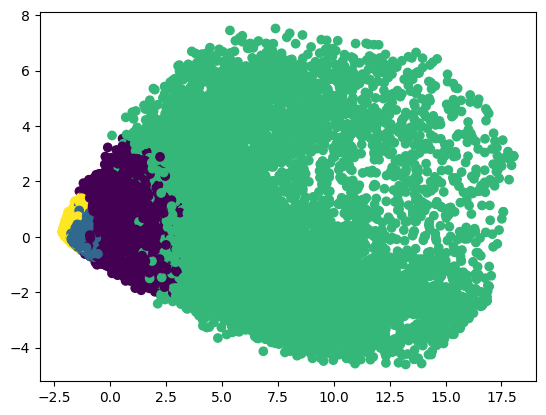

In [11]:
gm.scatter_plot(gm.pca(clus))

In [12]:
gm.pca(clus).value_counts('cluster')

cluster
2    32744
1    28877
4    25755
3    12566
dtype: int64